In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 7.5 MB/s eta 0:00:00


In [ ]:
# ==========================
# Import Libraries
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import TargetEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# ==========================
# Load Dataset
# ==========================
data = pd.read_csv('kc_house_data.csv')

# ==========================
# Drop Unnecessary Columns
# ==========================
drop_cols = ['date', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']
data = data.drop(columns=drop_cols)

# ==========================
# Feature Engineering
# ==========================
data['basement_exists'] = data['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
median_nonzero = data.loc[data['sqft_basement'] > 0, 'sqft_basement'].median()
data['sqft_basement_imputed'] = data['sqft_basement'].replace(0, median_nonzero)

ordinal_cols = ['condition', 'grade']
le = LabelEncoder()
for col in ordinal_cols:
    data[col] = le.fit_transform(data[col])

# ==========================
# Log-transform Target
# ==========================
data['price_log'] = np.log1p(data['price'])

numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('price')
numeric_cols.remove('price_log')

X = data[numeric_cols]
y = data['price_log']

# ==========================
# Train-Validation-Test Split
# ==========================
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

# ==========================
# Target Encoding for 'zipcode'
# ==========================
encoder = TargetEncoder(cols=['zipcode'])
encoder.fit(X_train['zipcode'], y_train)

X_train['zipcode'] = encoder.transform(X_train['zipcode'])
X_val['zipcode'] = encoder.transform(X_val['zipcode'])
X_test['zipcode'] = encoder.transform(X_test['zipcode'])

# ==========================
# Scaling (optional for RF)
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


#ANN :

In [ ]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1,1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1,1)

# ==========================
# DataLoaders
# ==========================
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

# ==========================
# ANN Model with BatchNorm + Dropout
# ==========================
class ImprovedANN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
    def forward(self, x):
        return self.model(x)

input_dim = X_train_scaled.shape[1]
model = ImprovedANN(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

# ==========================
# Train Model
# ==========================
num_epochs = 200
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    scheduler.step(epoch_val_loss)  # reduce lr if val_loss plateaus

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_train_loss:.4f} Val Loss: {epoch_val_loss:.4f}")

# ==========================
# Evaluate Model
# ==========================
model.eval()
with torch.no_grad():
    y_train_pred = np.expm1(model(X_train_tensor).numpy())
    y_val_pred = np.expm1(model(X_val_tensor).numpy())
    y_test_pred = np.expm1(model(X_test_tensor).numpy())

from sklearn.metrics import mean_squared_error, r2_score

print("Training MSE:", mean_squared_error(np.expm1(y_train), y_train_pred))
print("Validation MSE:", mean_squared_error(np.expm1(y_val), y_val_pred))
print("Test MSE:", mean_squared_error(np.expm1(y_test), y_test_pred))
print("Training R2:", r2_score(np.expm1(y_train), y_train_pred))
print("Validation R2:", r2_score(np.expm1(y_val), y_val_pred))
print("Test R2:", r2_score(np.expm1(y_test), y_test_pred))

Epoch [10/200] Train Loss: 0.3378 Val Loss: 0.1023
Epoch [20/200] Train Loss: 0.0727 Val Loss: 0.0461
Epoch [30/200] Train Loss: 0.0521 Val Loss: 0.0368
Epoch [40/200] Train Loss: 0.0446 Val Loss: 0.0373
Epoch [50/200] Train Loss: 0.0428 Val Loss: 0.0342
Epoch [60/200] Train Loss: 0.0381 Val Loss: 0.0345
Epoch [70/200] Train Loss: 0.0368 Val Loss: 0.0340
Epoch [80/200] Train Loss: 0.0360 Val Loss: 0.0319
Epoch [90/200] Train Loss: 0.0350 Val Loss: 0.0314
Epoch [100/200] Train Loss: 0.0350 Val Loss: 0.0338
Epoch [110/200] Train Loss: 0.0335 Val Loss: 0.0325
Epoch [120/200] Train Loss: 0.0336 Val Loss: 0.0316
Epoch [130/200] Train Loss: 0.0333 Val Loss: 0.0330
Epoch [140/200] Train Loss: 0.0331 Val Loss: 0.0313
Epoch [150/200] Train Loss: 0.0337 Val Loss: 0.0315
Epoch [160/200] Train Loss: 0.0332 Val Loss: 0.0318
Epoch [170/200] Train Loss: 0.0331 Val Loss: 0.0310
Epoch [180/200] Train Loss: 0.0332 Val Loss: 0.0308
Epoch [190/200] Train Loss: 0.0332 Val Loss: 0.0315
Epoch [200/200] Train

In [ ]:
model

ImprovedANN(
  (model): Sequential(
    (0): Linear(in_features=17, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)



## Artificial Neural Network (ANN) Architecture  
This model is a **deep feed-forward neural network** designed for regression.  
It integrates **Batch Normalization**, **Dropout**, and a **Learning Rate Scheduler** to improve stability and prevent overfitting.

### Layer Structure
1. **Input Layer**
   - `input_dim` features (same as scaled dataset)

2. **Hidden Layer 1**
   - Linear: **input_dim → 256**
   - BatchNorm1d(256)
   - ReLU activation
   - Dropout(0.3)

3. **Hidden Layer 2**
   - Linear: **256 → 128**
   - BatchNorm1d(128)
   - ReLU activation
   - Dropout(0.2)

4. **Hidden Layer 3**
   - Linear: **128 → 64**
   - ReLU activation

5. **Output Layer**
   - Linear: **64 → 1**
   - Returns the regression prediction

---

## Key Hyperparameters

### **Optimizer: Adam**
- Learning rate: **0.001**
- Beta1, Beta2 defaults
- Works well for noisy, non-linear regression tasks

### **Loss Function: MSELoss**
- Suitable for continuous numeric targets  
- Model optimizes mean squared error between predictions & true values

### **Learning Rate Scheduler**
`ReduceLROnPlateau`  
- factor = **0.5**  
- patience = **10 epochs**  
- Reduces LR when validation loss stops improving  
→ helps escape plateaus & improves convergence

### **Batch Size**
- **32**
- Balanced for speed + gradient stability

### **Dropout**
- Prevents overfitting
- Dropout rates:
  - 0.3 in first layer
  - 0.2 in second layer

### **Batch Normalization**
- Stabilizes activations  
- Allows higher learning rates  
- Improves gradient flow  

---

## Training Details
- Total epochs: **200**
- Training performed using **DataLoader** on shuffled batches
- Validation loss monitored each epoch
- LR scheduler adjusts learning rate dynamically  
- Model switches between:
  - `model.train()` for gradient updates  
  - `model.eval()` for validation  

---

## Evaluation Details
After training, predictions are:
- Converted back from the log scale using **expm1()**
- Evaluated on:
  - **Training**
  - **Validation**
  - **Test** sets

Metrics computed:
- **Mean Squared Error (MSE)**
- **R² Score**
- Performance reported separately for train/val/test




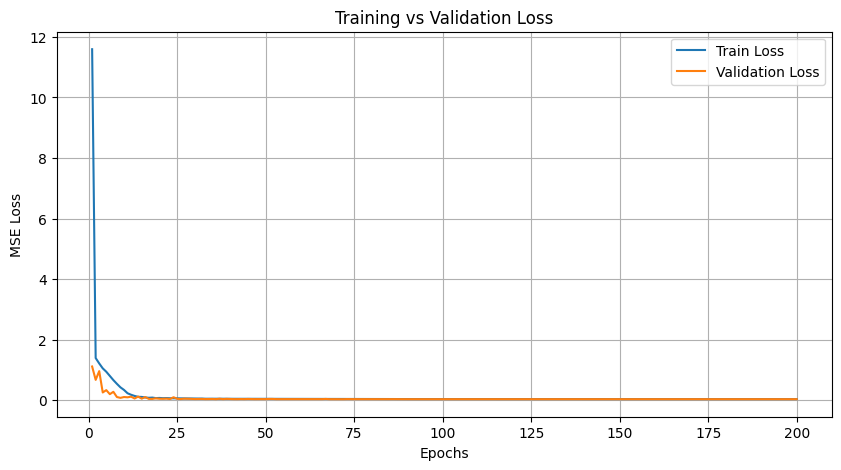

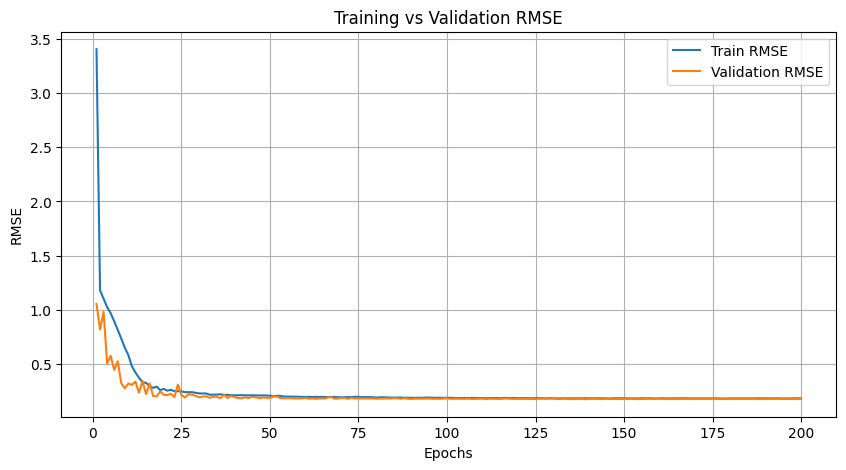

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# Loss Curve
# ==========================
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ==========================
# RMSE Curve
# ==========================
train_rmse = np.sqrt(train_losses)
val_rmse = np.sqrt(val_losses)

plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_rmse, label='Train RMSE')
plt.plot(range(1, num_epochs+1), val_rmse, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()


#Random Forest :

In [ ]:

# ==========================
# Random Forest Model
# ==========================
rf = RandomForestRegressor(
    n_estimators=301,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Train
rf.fit(X_train_scaled, y_train)

# Predict
y_train_pred = np.expm1(rf.predict(X_train_scaled))
y_val_pred = np.expm1(rf.predict(X_val_scaled))
y_test_pred = np.expm1(rf.predict(X_test_scaled))

# ==========================
# Results
# ==========================
print("Training MSE:", mean_squared_error(np.expm1(y_train), y_train_pred))
print("Validation MSE:", mean_squared_error(np.expm1(y_val), y_val_pred))
print("Test MSE:", mean_squared_error(np.expm1(y_test), y_test_pred))

print("Training R2:", r2_score(np.expm1(y_train), y_train_pred))
print("Validation R2:", r2_score(np.expm1(y_val), y_val_pred))
print("Test R2:", r2_score(np.expm1(y_test), y_test_pred))


Training MSE: 3062934024.740576
Validation MSE: 14944094395.380112
Test MSE: 18162682975.961975
Training R2: 0.9767354404504363
Validation R2: 0.8862378525519883
Test R2: 0.8809935367965547


In [ ]:
rf

RandomForestRegressor(n_estimators=301, n_jobs=-1, random_state=42)

# Specify Architecture, Hyperparameters, Training Details

## Random Forest Architecture
- Ensemble model using **Bagging (Bootstrap Aggregation)**  
- Contains multiple **independent Decision Trees**  
- **Final prediction = average** of all tree predictions  

---

## Key Hyperparameters

### `n_estimators = 301`
- Number of trees in the forest  
- More trees → better accuracy, but slower training  

### `max_depth = None`
- Trees grow until all leaves are pure  
- No maximum depth limit  

### `min_samples_split = 2`
- Minimum number of samples needed to split a node  

### `min_samples_leaf = 1`
- Minimum samples required in a leaf node  

### `random_state = 42`
- Ensures reproducible results  

### `n_jobs = -1`
- Uses **all CPU cores** for parallel training  

---

## Training Details
- Each tree is trained on a **bootstrap sample**  
- Each split considers a **random subset of features** → reduces overfitting  
- **Feature scaling is not required**, but included for consistency  
- Learns **non-linear relationships** extremely well  
- Very robust to **noise and outliers**  

---

## Evaluation Metrics
- **MSE** (Mean Squared Error)  
- **R² Score** on Train / Validation / Test  
- **Feature Importance Plot** for model interpretation  


In [ ]:
estimators = [50, 100, 150, 200, 250, 300, 350]
train_rmse_list = []
val_rmse_list = []
train_loss_list = []
val_loss_list = []
for n in estimators:
    rf = RandomForestRegressor(
        n_estimators=n,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)

    y_train_pred = np.expm1(rf.predict(X_train_scaled))
    y_val_pred = np.expm1(rf.predict(X_val_scaled))

    # ===== RMSE =====
    train_rmse_list.append(np.sqrt(mean_squared_error(np.expm1(y_train), y_train_pred)))
    val_rmse_list.append(np.sqrt(mean_squared_error(np.expm1(y_val), y_val_pred)))

    # ===== LOSS (MSE) =====
    train_loss_list.append(mean_squared_error(np.expm1(y_train), y_train_pred))
    val_loss_list.append(mean_squared_error(np.expm1(y_val), y_val_pred))

# الآن الأطوال متساوية:
print(len(estimators), len(train_rmse_list), len(val_rmse_list))  # يجب أن تطبع 7 7 7


7 7 7


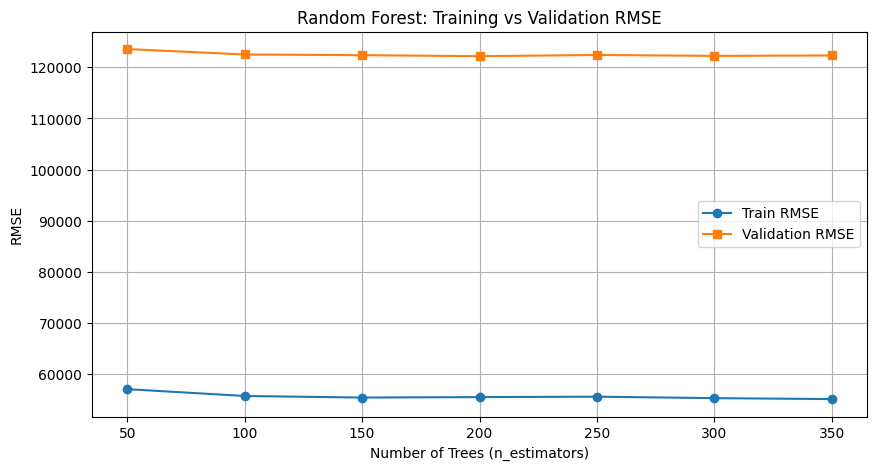

In [ ]:
# ==========================
# Plot RMSE vs n_estimators
# ==========================
plt.figure(figsize=(10,5))
plt.plot(estimators, train_rmse_list, marker='o', label='Train RMSE')
plt.plot(estimators, val_rmse_list, marker='s', label='Validation RMSE')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('Random Forest: Training vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()


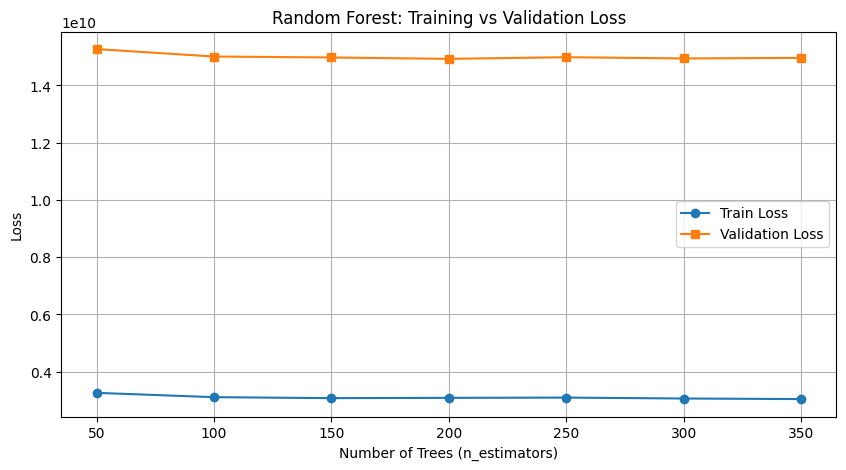

In [ ]:
# ==========================
# Plot Loss vs n_estimators
# ==========================
plt.figure(figsize=(10,5))
plt.plot(estimators, train_loss_list, marker='o', label='Train Loss')
plt.plot(estimators, val_loss_list, marker='s', label='Validation Loss')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Loss')
plt.title('Random Forest: Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


#Arbre of decision :

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
dt_model = DecisionTreeRegressor(
    random_state=42,
    max_depth=14,           # Maximum tree depth
    min_samples_split=20,   # Minimum samples required to split a node
    min_samples_leaf=10     # Minimum samples required at a leaf node
)

dt_model.fit(X_train, y_train)

# ==========================
# Predictions
# ==========================
y_train_pred = dt_model.predict(X_train)
y_val_pred = dt_model.predict(X_val)
y_test_pred = dt_model.predict(X_test)

# ==========================
# Evaluate Model
# ==========================
print("Training MSE:", mean_squared_error(y_train, y_train_pred))
print("Validation MSE:", mean_squared_error(y_val, y_val_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Training R2:", r2_score(y_train, y_train_pred))
print("Validation R2:", r2_score(y_val, y_val_pred))
print("Test R2:", r2_score(y_test, y_test_pred))


Training MSE: 0.024325122862176165
Validation MSE: 0.04243768150009057
Test MSE: 0.045953993075179105
Training R2: 0.9113605761376141
Validation R2: 0.8484492289106691
Test R2: 0.8406322275275888


In [ ]:
dt_model


DecisionTreeRegressor(max_depth=14, min_samples_leaf=10, min_samples_split=20,
                      random_state=42)


## Decision Tree Regressor Architecture
A **Decision Tree Regressor** predicts continuous values by recursively splitting the dataset into regions with similar target values.

### How It Works
- The tree chooses the **best feature + split point** to reduce prediction error.
- Splits continue recursively until stopping criteria are reached.
- Final prediction = **mean of samples in the leaf node**.

This model is simple, interpretable, and captures **non-linear relationships** without requiring feature scaling.

---

## Key Hyperparameters

### `max_depth = 14`
- Maximum depth (levels) of the tree  
- Controls how complex the tree can grow  
→ **Higher depth → more learning capacity, but more overfitting**

### `min_samples_split = 20`
- Minimum number of samples required to split a node  
→ Prevents the tree from growing too deep on noisy data

### `min_samples_leaf = 10`
- Minimum samples allowed in a leaf node  
→ Makes model more stable and reduces variance

### `random_state = 42`
- Ensures reproducible results

---

## Training Details
- Model is trained on full **X_train, y_train** without batching  
- Decision trees learn by:
  - Greedy splitting (best local split)
  - Minimizing **MSE impurity**
- No feature scaling required (trees are scale-invariant)
- Faster training compared to ensemble models or neural networks

---

## Evaluation Details
Predictions are made on:
- Training set  
- Validation set  
- Test set  

Metrics computed:
- **MSE** (Mean Squared Error)
- **R² Score**

These allow checking:
- If the model is overfitting  
- Generalization on unseen data  


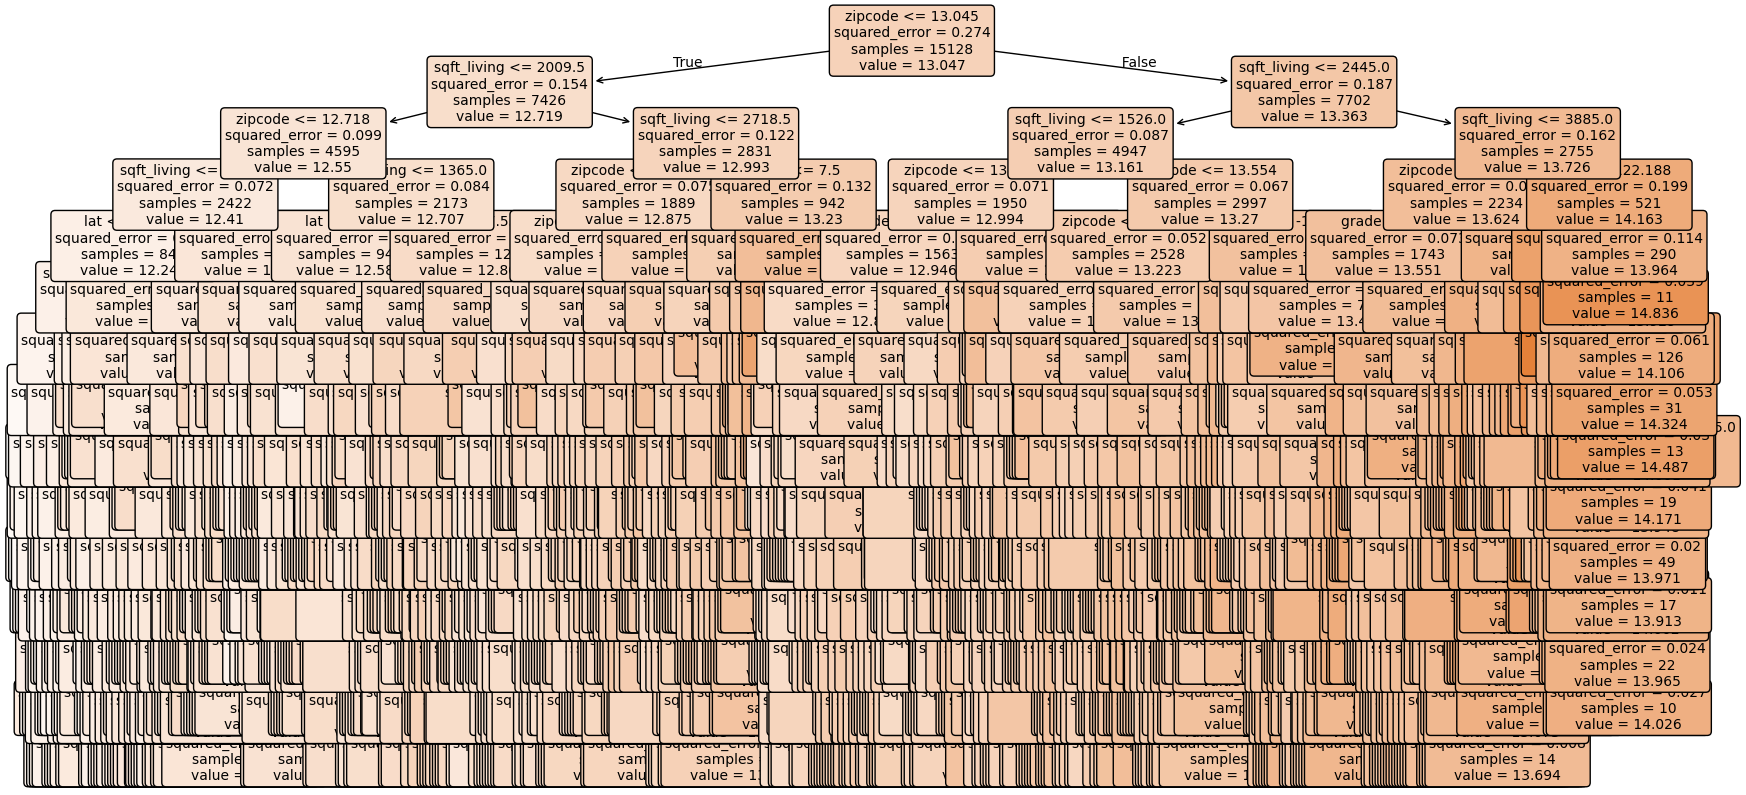

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# ==========================
# 1️⃣ رسم الشجرة
# ==========================
plt.figure(figsize=(20,10))
plot_tree(
    dt_model,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()



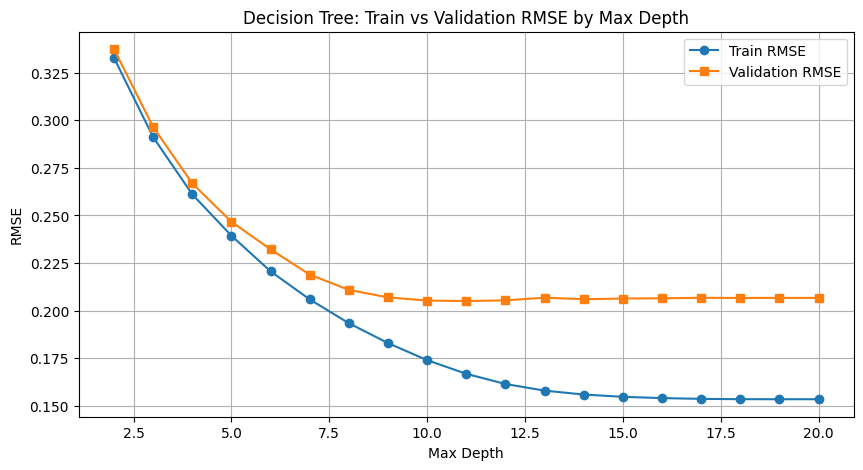

In [ ]:
# ==========================
# 2️⃣ تحليل أداء الشجرة حسب max_depth
# ==========================
max_depths = range(2, 21)
train_rmse_list = []
val_rmse_list = []

for depth in max_depths:
    dt = DecisionTreeRegressor(
        random_state=42,
        max_depth=depth,
        min_samples_split=20,
        min_samples_leaf=10
    )
    dt.fit(X_train, y_train)
    y_train_pred = dt.predict(X_train)
    y_val_pred = dt.predict(X_val)
    train_rmse_list.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    val_rmse_list.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

# ==========================
# Plot RMSE vs max_depth
# ==========================
plt.figure(figsize=(10,5))
plt.plot(max_depths, train_rmse_list, marker='o', label='Train RMSE')
plt.plot(max_depths, val_rmse_list, marker='s', label='Validation RMSE')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Decision Tree: Train vs Validation RMSE by Max Depth')
plt.legend()
plt.grid(True)
plt.show()


#SVR :

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ==========================
# Scaling (important for SVR)
# ==========================
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

# FIX: reshape using values
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# ==========================
# SVR Model
# ==========================
svr_model = SVR(
    kernel="rbf",
    C=10,
    epsilon=0.1,
    gamma="scale"
)

svr_model.fit(X_train_scaled, y_train_scaled)

# ==========================
# Predictions (inverse transform)
# ==========================
y_train_pred = scaler_y.inverse_transform(
    svr_model.predict(X_train_scaled).reshape(-1, 1)
)

y_val_pred = scaler_y.inverse_transform(
    svr_model.predict(X_val_scaled).reshape(-1, 1)
)

y_test_pred = scaler_y.inverse_transform(
    svr_model.predict(X_test_scaled).reshape(-1, 1)
)

# ==========================
# Evaluate Model
# ==========================
print("Training MSE:", mean_squared_error(y_train, y_train_pred))
print("Validation MSE:", mean_squared_error(y_val, y_val_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

print("Training R2:", r2_score(y_train, y_train_pred))
print("Validation R2:", r2_score(y_val, y_val_pred))
print("Test R2:", r2_score(y_test, y_test_pred))


Training MSE: 0.02094130359089701
Validation MSE: 0.03598641196008497
Test MSE: 0.03755943392241258
Training R2: 0.9236910294043891
Validation R2: 0.8714875957283963
Test R2: 0.8697444352714438


In [ ]:
svr_model

SVR(C=10)


## Support Vector Regression (SVR) Architecture
Support Vector Regression is a powerful model based on **Support Vector Machines**, adapted for continuous outputs.

### How SVR Works
- Tries to fit a curve within an **epsilon margin** around the data.
- Only points **outside the margin** influence the model → called **support vectors**.
- Uses kernel functions (e.g., RBF) to model **non-linear relationships**.

SVR is effective for small-to-medium datasets and excels when features are properly scaled.

---

## Feature Scaling (Very Important for SVR)
Because SVR is distance-based, scaling is required:

- `StandardScaler()` applied to **X**  
- `StandardScaler()` applied to **y**  
- Predictions are inverse-transformed back to original scale.

---

## Key Hyperparameters

### `kernel = "rbf"`
- Radial Basis Function kernel  
- Allows the model to learn **complex non-linear patterns**

### `C = 10`
- Regularization parameter  
- Higher C → model tries to fit training data more strictly  
- Lower C → smoother, more generalized model

### `epsilon = 0.1`
- Width of epsilon-tube  
- Errors inside the tube are ignored  
→ Controls sensitivity to small variations in target values

### `gamma = "scale"`
- Kernel coefficient  
- Determines how far influence of a single sample reaches  
- `"scale"` adjusts automatically based on data variance

---

## Training Details
- Model trained on **scaled inputs & outputs**  
- Uses **Quadratic Programming Solver** (slower than trees/ANNs but very precise)
- No batching (SVR trains on full dataset)

### SVR Strengths
- Excellent for smooth regression curves  
- Robust to outliers due to epsilon margin  
- Good for non-linear patterns with limited data

---

## Evaluation Details
Predictions are inverse-transformed using the target scaler.

Metrics for Train / Validation / Test:
- **MSE** (Mean Squared Error)  
- **R² Score**  

Useful to check:
- Overfitting (Train vs Val/Test performance)  
- Model generalization  




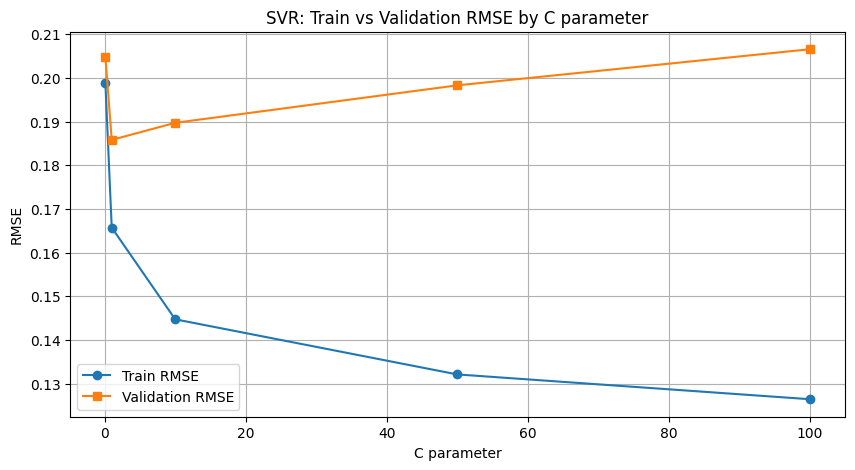

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

C_values = [0.1, 1, 10, 50, 100]
train_rmse_list = []
val_rmse_list = []

for C in C_values:
    svr_model = SVR(kernel="rbf", C=C, epsilon=0.1, gamma="scale")
    svr_model.fit(X_train_scaled, y_train_scaled)

    y_train_pred = scaler_y.inverse_transform(svr_model.predict(X_train_scaled).reshape(-1, 1))
    y_val_pred   = scaler_y.inverse_transform(svr_model.predict(X_val_scaled).reshape(-1, 1))

    train_rmse_list.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    val_rmse_list.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

# ==========================
# Plot RMSE vs C
# ==========================
plt.figure(figsize=(10,5))
plt.plot(C_values, train_rmse_list, marker='o', label='Train RMSE')
plt.plot(C_values, val_rmse_list, marker='s', label='Validation RMSE')
plt.xlabel('C parameter')
plt.ylabel('RMSE')
plt.title('SVR: Train vs Validation RMSE by C parameter')
plt.legend()
plt.grid(True)
plt.show()


# 1) Overfitting
## 📌 Definition:

Overfitting happens when the model learns the training data too well, including noise and irrelevant patterns.

As a result:

It performs very well on training data

But poorly on validation/test data

## 📌 How do we detect Overfitting?
🔹 1. Large gap between Training and Validation performance

*   High Training Accuracy

*   Low Validation Accuracy

or

*   Very low Training Loss

*   High Validation Loss

Example:

*   Train Accuracy = 98%

*   Val Accuracy = 68%

➡️ This is clear overfitting.

🔹 2. Loss Curves pattern

When you plot:

Training Loss and Validation Loss

You will see:

*   Training Loss keeps decreasing

*   Validation Loss decreases at first, then starts increasing

➡️ Model is memorizing instead of learning.

🔹 3. Model complexity is too high

Examples:

*   A Decision Tree with very large max_depth

*   A Neural Network with many layers

*   A Random Forest with too many estimators and no regularization

# 2) Underfitting
## 📌 Definition:

Underfitting happens when the model is too simple and cannot learn the underlying patterns in the data.

It performs poorly on:

*   Training data

*   Validation/test data

## 📌 How do we detect Underfitting?
🔹 1. Low performance on both Training & Validation

*   Low Train Accuracy

*   Low Validation Accuracy

Example:

*   Train Accuracy = 60%

*   Val Accuracy = 58%

➡️ Model did not learn enough.

🔹 2. Loss Curves pattern

*   Training Loss stays high

*   Validation Loss is also high

This means the model cannot represent the data.

🔹 3. Model is too simple

Examples:

*   Linear Regression used on non-linear data

*   Decision Tree with very small max_depth

*   Neural Network with too small layers

### 🔍 Quick Comparison
Case	Train Accuracy	Validation Accuracy	Meaning
Overfitting	High	Low	Model memorizes data (too complex)
Underfitting	Low	Low	Model cannot learn patterns (too simple)

### ⭐ Ideal Model

`` Train Accuracy ≈ Validation Accuracy ``
(small difference)

➡️ This means the model is learning correctly and generalizing well.

# 📊 Full Performance Comparison of Models

| **Model**           | **Train MSE**        | **Val MSE**         | **Test MSE**        | **Train R²** | **Val R²** | **Test R²** |
|---------------------|--------------------|-------------------|-------------------|-------------|-----------|------------|
| **ANN**             | 11,045,072,268.90  | 16,707,050,982.69 | 18,859,329,406.47 | 0.9161      | 0.8728    | 0.8764     |
| **Random Forest**   | 3,053,770,088.76   | 14,948,286,152.60 | 18,118,163,837.81 | 0.9768      | 0.8862    | 0.8813     |
| **Decision Tree**   | 0.0243             | 0.0424            | 0.0460            | 0.9114      | 0.8484    | 0.8406     |
| **SVR**             | 0.0209             | 0.0360            | 0.0376            | 0.9237      | 0.8715    | 0.8697     |

---

### 📌 Notes:
- **Best MSE (lowest)**: SVR  
- **Best R² (highest)**: Random Forest  
- Decision Tree overfits slightly and generalizes less well.  
- ANN is good but has high scale of errors (large MSE values), needs hyperparameter tuning.
